In [34]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

Let's see if Zipf's law holds in the 20 newsgroups corpus. Zipf's law states that the word frequency should be inversely proportional to the word rank 
$$
\text{frequency} \propto \frac{1}{\text{rank}^a}
$$
where $a$ is an exponent close to 1.

We'll remove headers and quotes from the messages.

In [2]:
remove = ('headers','quotes')

newsgroups_train = fetch_20newsgroups(subset='train',remove=remove)

The `CountVectorizer` counts the number of occurrences of each word, producing a `scipy` sparse `matrix`.

In [85]:
vectorizer = CountVectorizer(ngram_range=(1,1))
vectorizer.fit(newsgroups_train.data)

CountVectorizer()

In [86]:
counts = vectorizer.transform(newsgroups_train.data)

In [6]:
counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1238742 stored elements and shape (11314, 113393)>

To make plotting easier we'll turn the matrix with the word counts into a Pandas DataFrame, and use Seaborn to do the actual plotting.

In [15]:
vocab = pd.Series(vectorizer.vocabulary_).sort_values()
vocab

00               0
000              1
0000             2
00000            3
000000           4
             ...  
érale       113388
ête         113389
íålittin    113390
ñaustin     113391
ýé          113392
Length: 113393, dtype: int64

In [26]:
word_counts = pd.Series(dict(zip(vocab.index,np.array(counts.sum(axis=0)).flatten())))

The most common words are as expected the stop words, but there's a strange one: "ax" is the second most common word. It turns out that there are some messages entirely made of the word "AX" repeated a bunch of times, we'll take a closer look later.

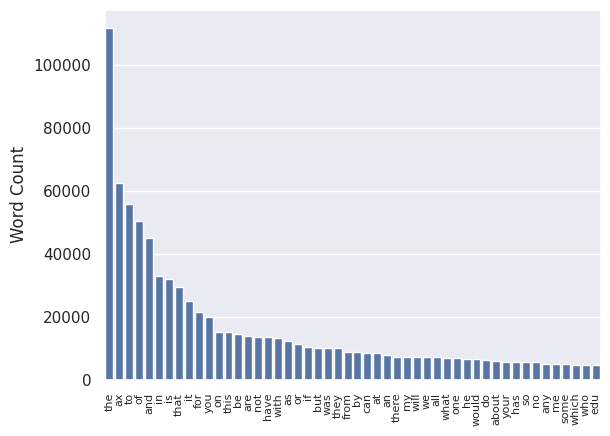

In [87]:
sns.barplot(word_counts.sort_values(ascending=False).head(50))
plt.ylabel('Word Count')
plt.xticks(rotation=90,size=8);

Let's plot against the rank, and check that Zipf's law works in this corpus:

In [ ]:
counts_ranked = word_counts.sort_values(ascending=False).reset_index().rename(columns={0:'count','index':'word'}).reset_index()
counts_ranked.head(5)

,index,word,count
0,0,the,112029
1,1,ax,62400
2,2,to,55726
3,3,of,50476
4,4,and,44974


The dashed line is $c/\text{rank}^0.95$, where $c$ is a constant eyeballed to be `1.75e5`. That looks like a pretty good power law.

Text(0.5, 0, 'Frequency Rank')

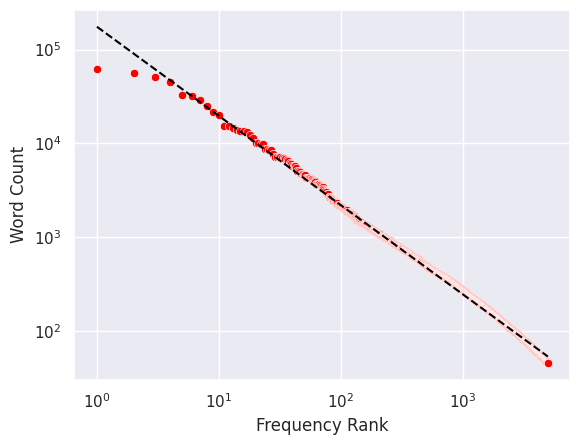

In [90]:
plt.plot(counts_ranked['index'].head(5000),1.75e5/counts_ranked['index'].head(5000)**0.95,color='black',linestyle='--')
sns.scatterplot(counts_ranked.head(5000),x='index',y='count',color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Word Count")
plt.xlabel("Frequency Rank")

# Wait, "ax" is the second most common word?

In [94]:
ax_idx = vocab['ax'] # index of the word 'ax'

There are only a few messages where the word 'ax' appears, but when it does it appears *a lot*.

In [96]:
doc_idx, _ = counts[:,ax_idx].nonzero() # find indices of nonzero entries along the 0 axis, i.e. documents with the 'ax' word
doc_idx

array([  144,   498,   724,  1492,  1506,  2208,  2931,  3198,  3382,
        4090,  4495,  4515,  4651,  4772,  5045,  7848,  8213,  8665,
        9080, 10558, 10650, 10963, 11057], dtype=int32)

In [103]:
for idx in doc_idx:
    print(f"Sample from document {idx}")
    print(newsgroups_train.data[idx][:100],end='\n\n')

Sample from document 144

MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'
MAX>'AX>'AX>'AX>',3'$9F8+"Z5'1]_?W]_?

Sample from document 498
---------- cut here ---------- part 01/01
begin 644 1260wn31.exe
M35KO 1D    & -$,__\@ P $     ?#_'@

Sample from document 724

Well, actually, most of ours is based on what really happened and yours is
based on some fantasy of

Sample from document 1492

------------ Part 3 of 14 ------------
M"`@("`@("`@("`@("`@(G.3DY.3DY.3DY.3DY.3DY.3DY.3DY.2#IJ:FIJ:

Sample from document 1506

------------ Part 6 of 14 ------------
MAZ)75U=7R!1KP"5A8=F>`7;UG)\&V0&>*YZ>*W5&$'Z]M;T0AX>'AX>'AX>

Sample from document 2208
 

Finding the circumcenter of a tetrahedron is discussed on page 33 in

CONTOURING: A guide to the 

Sample from document 2931


------------ Part 14 of 14 ------------
M<1D9&;"P4U/M[>V+BXN+-#0T-#0TQ33%Q6=G9V=G#P\/#P\/9V?%Q<7%Q

Sample from document 3198

------------ Part 5 of 14 ------------
M)B9R&KJZ)EVZ=+ITNKH>?7U=PGU]+"Q=?72_="PU

Mystery solved: a few documents genuinely contain that word (e.g in the expression "getting the ax'), but in most caes it looks like eiter a binary dump or a cryptographic key. If we're interested in natural language proper we should clean up the latter documents.